# Object localization with Stanford Dogs Dataset

In [1]:
import time
import os
import random
import math
import re
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from PIL import Image
import progressbar
import my_utils
from sklearn.cross_validation import train_test_split
plt.ion()

D:\Users\Home\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This study utilizes the Stanford Dogs Dataset.Our aim is to learn to localize a frame on the part of the image containing a dog.

In [2]:
path_source='d:/Users/Home/Desktop/Open-U/Localization1/'
path_source1='d:/Users/Home/Desktop/Open-U/Localization1/Annotation'
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Each image is accompanied with information file.The information includes the size of the image and the 2 coordinates of the frame 
(Xmin,Ymin) and (Xmax,Ymax) .As a first step we will create two txt files:
images: partial path to given image. 
bounding_boxes: x_min,y_min,width,heigh of bounding box corresponding to image.
Every entry in each of the files is enumerated in correspondance.

In [3]:
dirs = [entry.path for entry in os.scandir(path_source1) if entry.is_dir()]

In [127]:
#Preprocessing: Creating 2 txt files 
#1-images: partial path to given image 
#2-bounding boxes: x_min,y_min,width,heigh of given bounding box

In [4]:
cnt=1
images_names_list=[]
bounding_boxes_list=[]
for dir_name in dirs:
   # len(path_source)+len('Annotation')
    sub_folder_name=path_source1+dir_name[(len(path_source1)):]  
    file_names=os.listdir(sub_folder_name) 
    for file in file_names: 
        file_name=sub_folder_name+'/'+file  
        f = open(file_name, 'r', encoding="utf-8")
        file_content=f.readlines() 
        image_str=str(cnt)+' '
        f_name=str(re.findall(r'<filename>(.+?)</filename>', file_content[2])[0])
        if(f_name!='%s'): 
            image_str=image_str+dir_name[(len(path_source)+len('Annotation'))+1:]+'/'+f_name+'.jpg'        
            images_names_list.append(image_str)           
            bounding_box_str=str(cnt)+' '
            x_min=float(re.findall(r'<xmin>(.+?)</xmin>', file_content[18])[0] )
            y_min=float(re.findall(r'<ymin>(.+?)</ymin>', file_content[19])[0] )
            x_max=float(re.findall(r'<xmax>(.+?)</xmax>', file_content[20])[0] )
            y_max=float(re.findall(r'<ymax>(.+?)</ymax>', file_content[21])[0] )         
            box_w=x_max-x_min
            box_h=y_max-y_min            
            bounding_box_str=bounding_box_str+str(x_min)+' '+str(y_min)+' '+str(box_w)+' '+str(box_h)
            bounding_boxes_list.append(bounding_box_str)
            cnt+=1

In [5]:
with open('d:/Users/Home/Desktop/Open-U/Localization1/images.txt', 'w') as t:
        for item in images_names_list:
            t.write("%s\n" % item) 

In [6]:
with open('d:/Users/Home/Desktop/Open-U/Localization1/bounding_boxes.txt', 'w') as f:
        for item in bounding_boxes_list:
            f.write("%s\n" % item)

In [7]:
path=path_source

Preparation of the train and test data sets

In [8]:
def split(ratio):
    arr=np.arange(len(images_names_list))
    #make the array start from 1 to length of our image list including the last index
    arr=np.add(arr,1)
    X_train, X_test = train_test_split( arr,  test_size=ratio, random_state=42)
    X_train,X_test = X_train.astype(np.str).tolist(),X_test.astype(np.str).tolist()
    return X_train,X_test

In [9]:
X_train,X_test=split(0.3)

In [10]:
class Dataset(Dataset):
    def __init__(self, im_ids, transform=None):
        with open(path+'images.txt') as f:
            id_to_path = dict([l.split(' ', 1) for l in f.read().splitlines()])
            
        with open(path+'bounding_boxes.txt') as t:
            id_to_frame = dict()
            for line in t.read().splitlines():
                im_id, *frame = line.split(' ')
                id_to_frame[im_id] = list(map(float, frame))
        self.imgs = [(os.path.join(path+'Images', id_to_path.get(i)), id_to_frame.get(i))
                     for i in im_ids]
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Scale((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(MEAN, STD)
            ])
        else:
            self.transform = transform
            
    def __getitem__(self, index):
        path, frame = self.imgs[index]
        im = Image.open(path).convert('RGB')
        im_size = np.array(im.size, dtype='float32')
        frame = np.array(frame, dtype='float32')
        
        im = self.transform(im)
        
        return im, frame, im_size
    
    def __len__(self):
        return len(self.imgs)

In [11]:
splits = {'train': X_train, 'test': X_test}
datasets = {split: Dataset(splits[split]) for split in ('train', 'test')}

D:\Users\Home\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Image and frame drawing/visualization functions

In [12]:
def imshow(img, frame, pred_frame=None):
    plt.imshow(img)
    draw_frame(frame,img)
    if pred_frame is not None:
        draw_frame(pred_frame,img,'red')        

def to_img(im):
    inp = im.numpy().transpose((1, 2, 0))
    mean = np.array(MEAN)
    std = np.array(STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp  

def draw_frame(frame,img, color='green'):
    x, y, w, h = my_utils.transRect_inv(frame, img.shape[:2][::-1])[0]
    if x == 0:
         x = 1
    if y == 0:
         y = 1
    plt.gca().add_patch(
        plt.Rectangle((x, y), w, h,fill=False, edgecolor=color, linewidth=3, alpha=0.6)
    )

Let us randomaly pick an image and draw it's corresponding frame

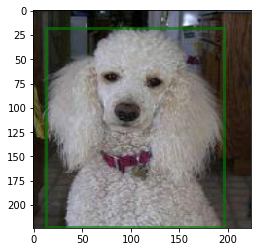

In [13]:
ind = random.choice(range(len(datasets['train'])))
im, frame, im_size = datasets['train'][ind]
frame = my_utils.transRect(frame, im_size)
imshow(to_img(im), frame[0])

In [43]:
dataloaders = {split: torch.utils.data.DataLoader(
                datasets[split], batch_size=32,shuffle=(split=='train')) for split in ('train', 'test')}

dtype = torch.cuda.FloatTensor
model = models.resnet18(pretrained=True)
fc_in_size = model.fc.in_features
model.fc = nn.Linear(fc_in_size, 4)
model = model.cuda()
criterion = nn.SmoothL1Loss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

best_epoch = -1
best_acc = 0.0

In [44]:
epoch_loss = {'train': [], 'test': []}
epoch_accuracy = {'train': [], 'test': []}
epochs = 10

In [45]:
torch.cuda.empty_cache()

Train

In [46]:
for epoch in range(epochs):
    running_accuracy = my_utils.AverageMeter()
    running_loss = my_utils.AverageMeter() 
    scheduler.step()
    model.train(True)            
    end = time.time()
    bar = progressbar.ProgressBar()
    for ims, frames, im_sizes in bar(dataloaders['train']):
        frames = my_utils.formRect(frames, im_sizes)
        frames = my_utils.transRect(frames, im_sizes)
            
        inputs = ims.type(dtype)
        targets = frames.type(dtype)
            
        optimizer.zero_grad()            
        #forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = my_utils.calcAccuracy(outputs.data.cpu(), targets.data.cpu(), im_sizes)

            
        nsample = inputs.size(0)
        running_accuracy.update(acc, nsample)
        running_loss.update(loss.data[0], nsample)            
        
        loss.backward()
        optimizer.step()
            
        elapsed_time = time.time() - end
    print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
        'train', epoch+1, epochs, running_loss.avg, running_accuracy.avg, elapsed_time))
    epoch_loss['train'].append(running_loss.avg)
    epoch_accuracy['train'].append(running_accuracy.avg) 

N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--D:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (437 of 437) |######################| Elapsed Time: 0:05:15 Time:  0:05:15
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 1/10	Loss: 0.0421	Acc: 33.48%	Time: 316.231


100% (437 of 437) |######################| Elapsed Time: 0:02:50 Time:  0:02:50
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 2/10	Loss: 0.0192	Acc: 54.97%	Time: 171.015


100% (437 of 437) |######################| Elapsed Time: 0:02:49 Time:  0:02:49
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 3/10	Loss: 0.0147	Acc: 62.14%	Time: 169.370


100% (437 of 437) |######################| Elapsed Time: 0:02:48 Time:  0:02:48
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 4/10	Loss: 0.0123	Acc: 65.67%	Time: 168.961


100% (437 of 437) |######################| Elapsed Time: 0:02:49 Time:  0:02:49
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 5/10	Loss: 0.0096	Acc: 70.18%	Time: 169.430


100% (437 of 437) |######################| Elapsed Time: 0:02:49 Time:  0:02:49
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 6/10	Loss: 0.0050	Acc: 82.19%	Time: 169.288


100% (437 of 437) |######################| Elapsed Time: 0:02:52 Time:  0:02:52
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 7/10	Loss: 0.0037	Acc: 85.85%	Time: 172.467


100% (437 of 437) |######################| Elapsed Time: 0:02:49 Time:  0:02:49
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 8/10	Loss: 0.0031	Acc: 87.16%	Time: 169.367


100% (437 of 437) |######################| Elapsed Time: 0:02:49 Time:  0:02:49
N/A% (0 of 437) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

[train]	Epoch: 9/10	Loss: 0.0025	Acc: 89.33%	Time: 169.490


100% (437 of 437) |######################| Elapsed Time: 0:02:48 Time:  0:02:48


[train]	Epoch: 10/10	Loss: 0.0021	Acc: 90.64%	Time: 169.145


In [288]:
#Test

In [77]:
epochs=1
model=model.cuda()

In [78]:
for epoch in range(epochs):
    running_accuracy = my_utils.AverageMeter()
    running_loss = my_utils.AverageMeter() 
    with torch.no_grad():
        model.train(False)             
        end = time.time()
        bar = progressbar.ProgressBar()
        for ims, frames, im_sizes in bar(dataloaders['test']):
            frames = my_utils.formRect(frames, im_sizes)
            frames = my_utils.transRect(frames, im_sizes)
            
            inputs = ims.type(dtype)
            targets = frames.type(dtype)  
            
            optimizer.zero_grad()
            
           # model=model.cuda()    
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = my_utils.calcAccuracy(outputs.data.cpu(), targets.data.cpu(), im_sizes)
            
            nsample = inputs.size(0)
            running_accuracy.update(acc, nsample)
            running_loss.update(loss.data[0], nsample)
            
        elapsed_time = time.time() - end         
        print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
            'test', epoch+1, epochs, running_loss.avg, running_accuracy.avg, elapsed_time))
        epoch_loss['test'].append(running_loss.avg)
        epoch_accuracy['test'].append(running_accuracy.avg)

N/A% (0 of 188) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--D:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (188 of 188) |######################| Elapsed Time: 0:01:38 Time:  0:01:38


[test]	Epoch: 1/1	Loss: 0.0506	Acc: 61.77%	Time: 98.458


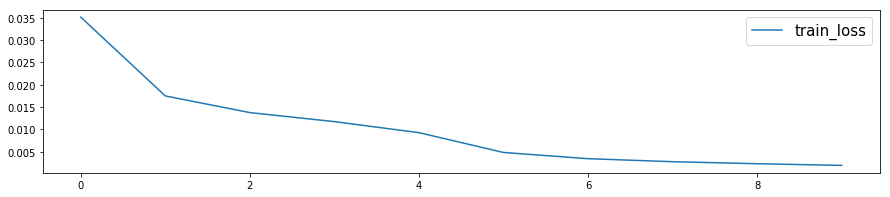

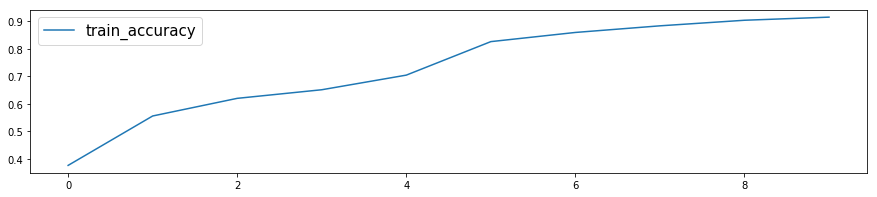

In [30]:
plt.figure(figsize=(15,3))
plt.plot(range(len(epoch_loss['train'])), epoch_loss['train'], label=('train_loss')) 
plt.legend(prop={'size': 15})
plt.figure(figsize=(15,3))
plt.plot(range(len(epoch_accuracy['train'])), epoch_accuracy['train'], label=( 'train_accuracy'))    
plt.legend(prop={'size': 15})

In [84]:
#model.load_state_dict(optim_model)
model = model.cpu()

In [87]:
ind = random.choice(range(len(datasets['test'])))
im, frame, im_size = datasets['test'][ind]
path, _ = datasets['test'].imgs[ind]
frame = my_utils.transRect(frame, im_size)[0]

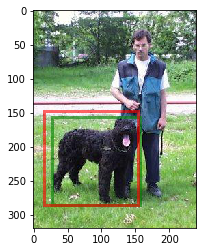

In [88]:
pred_frame = model(Variable(im.unsqueeze(0))).data[0]
ori_im = np.array(Image.open(path))
imshow(ori_im, frame, pred_frame)


The green frame is the acctual data frame while the red one is the predicted.